In [98]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

In [99]:
csv = "../../data/cleaned/final_clean_data1.csv"
df = pd.read_csv(csv)

In [100]:
df.size

3419

In [101]:
heart_keywords = [
    'heart', 'cardiac', 'cardiomegaly', 'cardiothoracic', 'cardiovascular',
    'cardiopulmonary', 'vascular', 'aorta', 'aortic', 'ventricle', 'ventricular',
    'atrium', 'atrial', 'pericardial', 'pericardium', 'enlargement', 'heart_size',
    'mediastinum', 'mediastinal', 'silhouette', 'congestive', 'congestion',
    'vascularity', 'vascular_congestion', 'cardiac_border', 'cardiomegalia',
    'cardiac_enlargement', 'cardiomediastinal'
]
lung_keywords = [
    'lung', 'lungs', 'pulmonary', 'pleural', 'pleura', 'pneumothorax',
    'infiltrate', 'infiltration', 'opacity', 'opacities', 'consolidation',
    'emphysema', 'hyperinflation', 'interstitial', 'atelectasis', 'edema',
    'bronchial', 'bronchi', 'airspace', 'alveolar', 'fibrosis', 'pneumonia',
    'trachea', 'hilar', 'effusion', 'hemithorax', 'costophrenic', 'parenchymal',
    'bilateral', 'unilateral', 'lobar', 'lobes', 'upper_lobe', 'lower_lobe', 'bilateral_pulmonary_nodule'
]

def assign_subject_code(text):
    heart_score = sum(1 for word in heart_keywords if word in text)
    lung_score = sum(1 for word in lung_keywords if word in text)
    
    if lung_score > heart_score:
        return 1  # Poumon
    elif heart_score > lung_score:
        return 2  # Cœur
    else:
        return 0  # Inconnu

df['sujet'] = df['combined_text'].apply(assign_subject_code)

In [102]:
# Séparer les datasets
df_lung = df[df['sujet'] == 1].reset_index(drop=True)
df_heart = df[df['sujet'] == 2].reset_index(drop=True)

# (Optionnel) Afficher les tailles
print(f" Poumon : {len(df_lung)} lignes")
print(f" Cœur : {len(df_heart)} lignes")

 Poumon : 2741 lignes
 Cœur : 396 lignes


In [103]:
df_lung

,combined_text,sujet
0,cardiac silhouette mediastinum size within nor...,1
1,cardiomediastinal silhouette within normal lim...,1
2,increased_opacity within right_upper_lobe poss...,1
3,interstitial marking diffusely prominent throu...,1
4,heart size pulmonary vascularity appear within...,1
...,...,...
2736,heart size normal lung clear normal pneumonia ...,1
2737,lung clear cardiomediastinal silhouette within...,1
2738,sternotomy suture bypass graft placed interval...,1
2739,calcified mediastinal focal area consolidation...,1


In [104]:
df_heart

,combined_text,sujet
0,lung clear epanded heart mediastinum normal ac...,2
1,cardiac mediastinal contour within normal limi...,2
2,cardiac mediastinal contour within normal limi...,2
3,heart top normal size mediastinum unremarkable...,2
4,heart lung interval lung clear epanded change ...,2
...,...,...
391,heart size cardiomediastinal silhouette pulmon...,2
392,heart top normal size mediastinum stable lung ...,2
393,status post posterior spinal fusion stable app...,2
394,heart lung interval lung clear epanded heart m...,2


In [105]:
df

,combined_text,sujet
0,cardiac silhouette mediastinum size within nor...,1
1,cardiomediastinal silhouette within normal lim...,1
2,lung clear epanded heart mediastinum normal ac...,2
3,increased_opacity within right_upper_lobe poss...,1
4,interstitial marking diffusely prominent throu...,1
...,...,...
3414,lung clear cardiomediastinal silhouette within...,1
3415,sternotomy suture bypass graft placed interval...,1
3416,calcified mediastinal focal area consolidation...,1
3417,cardiomediastinal silhouette demonstrates norm...,2


In [106]:
def contamination_function_bis(data1, data2, contamination_rate=0.4):
    """
    Fonction qui génère des anomalie dans notre jeu de données data1, en injectant des donnée de data2.
    
    - data1 : Corpus de données sain
    - data2 : Corpus de données considérées "anomalie"
    - contamination_rate : le taux de document contaminé par rapport a la taille de data1
    
    retourne un nouveau corpus de données avec des anomalies + les indices des anomalies
    """
    contamination_log = []
    
    #on contamine % des documents dans data1 
    df_size = max(1, int(len(data1) * contamination_rate))  
    selected_indices = random.sample(range(len(data1)), df_size)
    
    for i in selected_indices:
        base_text = data1[i]
        new_text = random.choice(data2)
        data1[i] = new_text  # remplacement de la ligne 

        # un log pour surveiller le fonctionnement de la fonction (à ajouter dans le return)
        contamination_log.append({
            "base_text": base_text,  # le texte original avant remplacement
            "contaminated_text": new_text,  # le texte après remplacement
            "index_replaced": i  # l'index de la ligne modifiée
        })

    return data1, selected_indices

In [107]:
new_df, indice = contamination_function_bis(df_lung['combined_text'], df_heart['combined_text'] )

/tmp/ipykernel_7417/2776884391.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[i] = new_text  # remplacement de la ligne


In [108]:
def vetorisation_sbert(data, indice_anomalie=None):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : noraml)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(40, 20)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

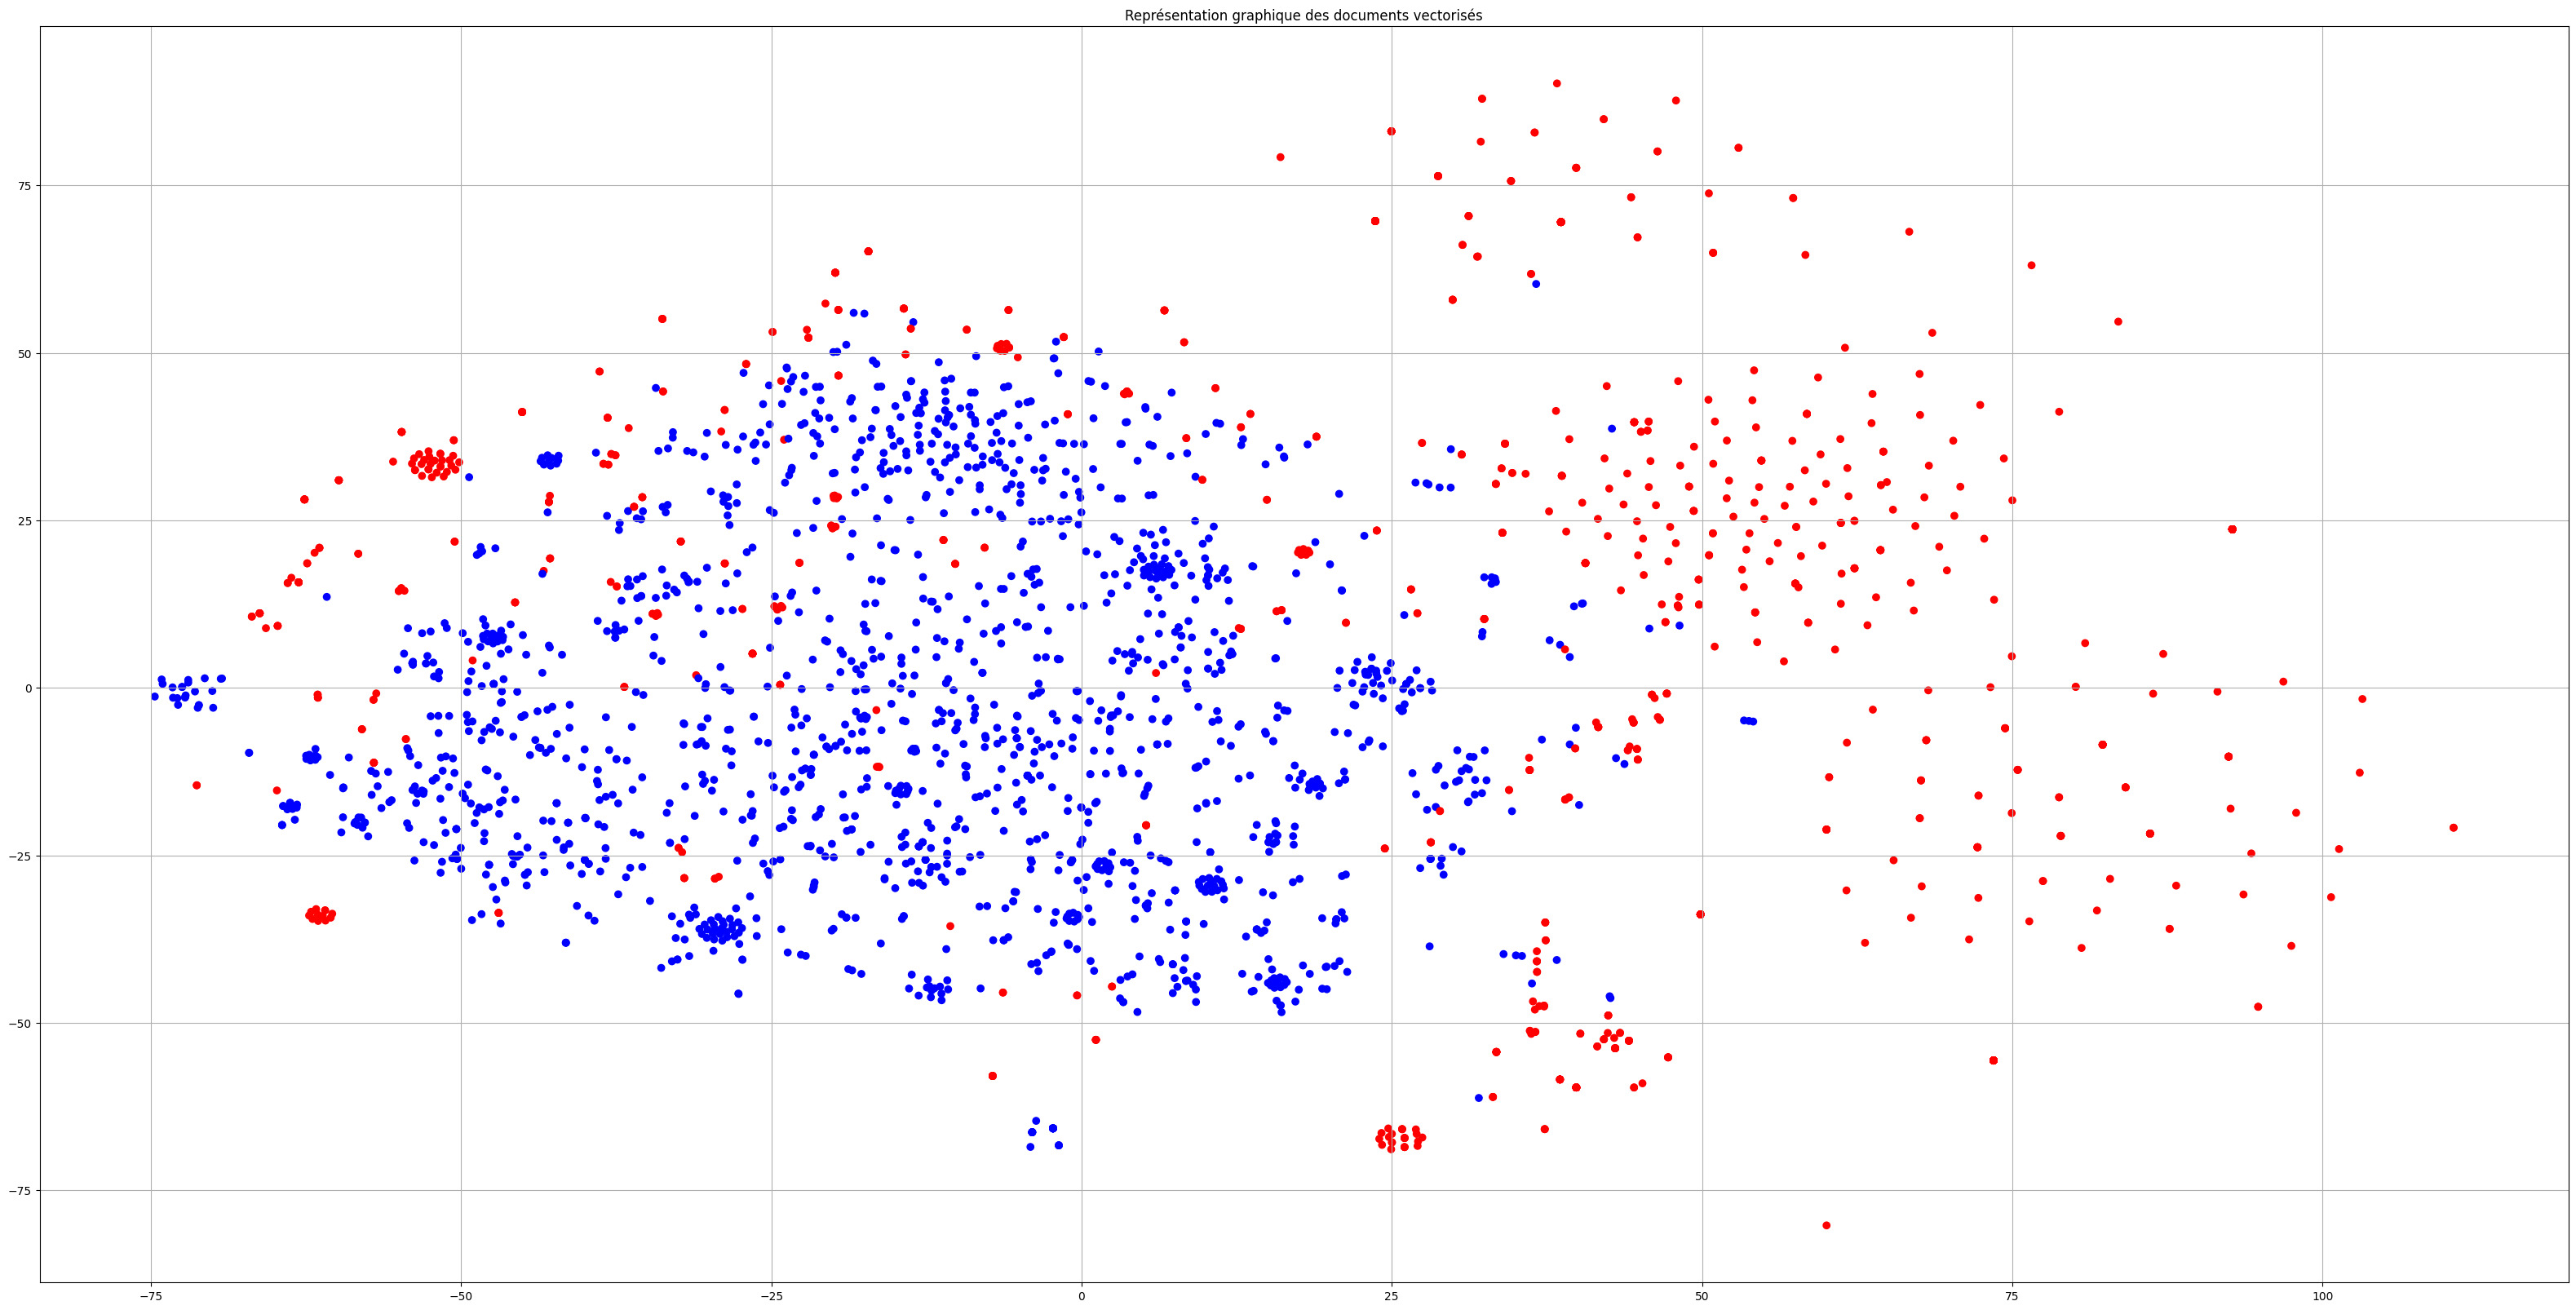

array([[ 0.07359835, -0.00371837,  0.03122334, ...,  0.07557542,
         0.02467717,  0.06454139],
       [ 0.08086951,  0.0399133 ,  0.01529451, ...,  0.0049861 ,
        -0.00064547,  0.03883004],
       [ 0.08932851,  0.00335531,  0.03597087, ...,  0.0717705 ,
        -0.06440374,  0.03891193],
       ...,
       [ 0.05267163,  0.04413804, -0.01582967, ..., -0.00393559,
        -0.02403714,  0.10183443],
       [ 0.15610385, -0.04686337, -0.006222  , ...,  0.01269923,
        -0.01770326, -0.0500242 ],
       [ 0.07578477,  0.03141014, -0.01138095, ...,  0.03126044,
        -0.00436647,  0.08781637]], dtype=float32)

In [109]:
vetorisation_sbert(new_df, indice)

In [110]:
new_df.to_csv('../../data/contaminated/contaminated_data_bis.csv', index=False)

In [111]:
np.save("../../data/contaminated/indices_anomalies_bis.npy", indice)